Hand-In of Group 13, Jonathan Ehrengruber (jonathan.ehrengruber@students.fhnw.ch), Christian Renold (christian.renold@hslu.ch)

In [2]:
# setup_gpus() function for configuration the gpu on icolab jupyter hub implemented in separate file for reusability
import gpu_init

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPU
GPU Setup done


In [6]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

In [4]:
# First, import TF and get its version.
import tensorflow as tf
tf_version = tf.__version__

# Check if version >=2.0.0 is used
if not tf_version.startswith('2.'):
    print('WARNING: TensorFlow >= 2.0.0 will be used in this course.\nYour version is {}'.format(tf_version) + '.\033[0m')
else:
    print('OK: TensorFlow >= 2.0.0' + '.\033[0m')

OK: TensorFlow >= 2.0.0.


In [5]:
def plot_log(log_local):
    f = plt.figure(figsize=(12,4))
    ax1 = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    ax1.plot(log_local.history['loss'], label='Training loss')
    ax1.plot(log_local.history['val_loss'], label='Testing loss')
    ax1.legend()
    ax1.grid()
    ax2.plot(log_local.history['accuracy'], label='Training acc')
    ax2.plot(log_local.history['val_accuracy'], label='Testing acc')
    ax2.legend()
    ax2.grid()

# Exercise 1: Functional API of Keras

Make sure first that you understand the principles of Keras functional API (slides 8–21). Using the CIFAR10 dataset :
* Re-use one of your best CNN architecture from PW08 or PW09 and transform the model definition from Sequential to the functional API. Observe that you get the same number of parameters and similar performances between the sequential and functional models.

In [9]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
n_classes = np.unique(y_train).shape[0]
X_train, X_test = X_train / 255.0, X_test / 255.0
Y_train, Y_test = utils.to_categorical(y_train), utils.to_categorical(y_test)

In [6]:
# Sequential Implementation:
cnn = Sequential([
    Conv2D(64, kernel_size=(3,3), input_shape=(32,32,3,), activation='relu'),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D((4, 4)),
    Flatten(),
    Dense(units=128, activation='relu', kernel_regularizer=l2(1e-2)),
    Dropout(0.2),
    Dense(units=10, activation='softmax')
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               200832    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [7]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
log = cnn.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=256)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 9s 174us/sample - loss: 2.0931 - accuracy: 0.3666 - val_loss: 1.5817 - val_accuracy: 0.4883
Epoch 2/20
50000/50000 [==============================] - 6s 119us/sample - loss: 1.5188 - accuracy: 0.4993 - val_loss: 1.4473 - val_accuracy: 0.5384
Epoch 3/20
50000/50000 [==============================] - 6s 119us/sample - loss: 1.4117 - accuracy: 0.5410 - val_loss: 1.3881 - val_accuracy: 0.5658
Epoch 4/20
50000/50000 [==============================] - 6s 119us/sample - loss: 1.3342 - accuracy: 0.5757 - val_loss: 1.3091 - val_accuracy: 0.5896
Epoch 5/20
50000/50000 [==============================] - 6s 120us/sample - loss: 1.2737 - accuracy: 0.5994 - val_loss: 1.2289 - val_accuracy: 0.6189
Epoch 6/20
50000/50000 [==============================] - 6s 120us/sample - loss: 1.2341 - accuracy: 0.6146 - val_loss: 1.1830 - val_accuracy: 0.6387
Epoch 7/20
50000/50000 [==========================

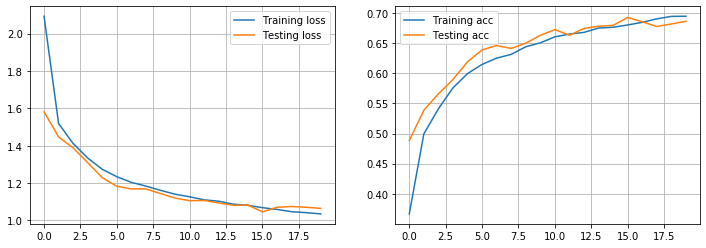

In [8]:
plot_log(log)

In [9]:
visible = Input(shape=(32,32,3,))
hidden1 = Conv2D(64, kernel_size=(3,3), input_shape=(32,32,3,), activation='relu')(visible)
hidden2 = Conv2D(32, kernel_size=(3,3), activation='relu')(hidden1)
hidden3MaxPool = MaxPooling2D((4,4))(hidden2)
hidden4Flatten = Flatten()(hidden3MaxPool)
hidden5 = Dense(units=128, activation='relu', kernel_regularizer=l2(1e-2))(hidden4Flatten)
hidden6 = Dropout(0.2)(hidden5)
output = Dense(units=10, activation='softmax')(hidden6)
modelFunctional = Model(inputs=visible, outputs=output)
modelFunctional.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        1792      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               200832    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [10]:
modelFunctional.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
logF = modelFunctional.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=256)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 7s 138us/sample - loss: 2.0681 - accuracy: 0.3848 - val_loss: 1.5557 - val_accuracy: 0.4920
Epoch 2/20
50000/50000 [==============================] - 6s 119us/sample - loss: 1.4813 - accuracy: 0.5208 - val_loss: 1.4075 - val_accuracy: 0.5596
Epoch 3/20
50000/50000 [==============================] - 6s 118us/sample - loss: 1.3710 - accuracy: 0.5630 - val_loss: 1.2887 - val_accuracy: 0.5983
Epoch 4/20
50000/50000 [==============================] - 6s 119us/sample - loss: 1.3074 - accuracy: 0.5859 - val_loss: 1.2666 - val_accuracy: 0.6112
Epoch 5/20
50000/50000 [==============================] - 6s 119us/sample - loss: 1.2707 - accuracy: 0.6004 - val_loss: 1.2275 - val_accuracy: 0.6225
Epoch 6/20
50000/50000 [==============================] - 6s 119us/sample - loss: 1.2253 - accuracy: 0.6189 - val_loss: 1.1815 - val_accuracy: 0.6396
Epoch 7/20
50000/50000 [==========================

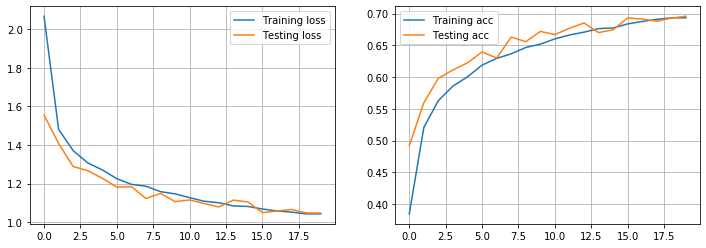

In [11]:
plot_log(logF)

Sequential Model: Accuracy Train: **0.6945**, Accuracy Test: **0.6861**

Functional Model: Accuracy Train: **0.6932**, Accuracy Test: **0.6957**

--> We achieve similar performances with functional models compared to the sequential model above.

## Experimental Model (#2): Multiple Paths

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 30, 30, 64)   1792        input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 27, 27, 64)   6976        input_6[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 30, 30, 64)   0           conv2d_12[0][0]                  
____________________________________________________________________________________________

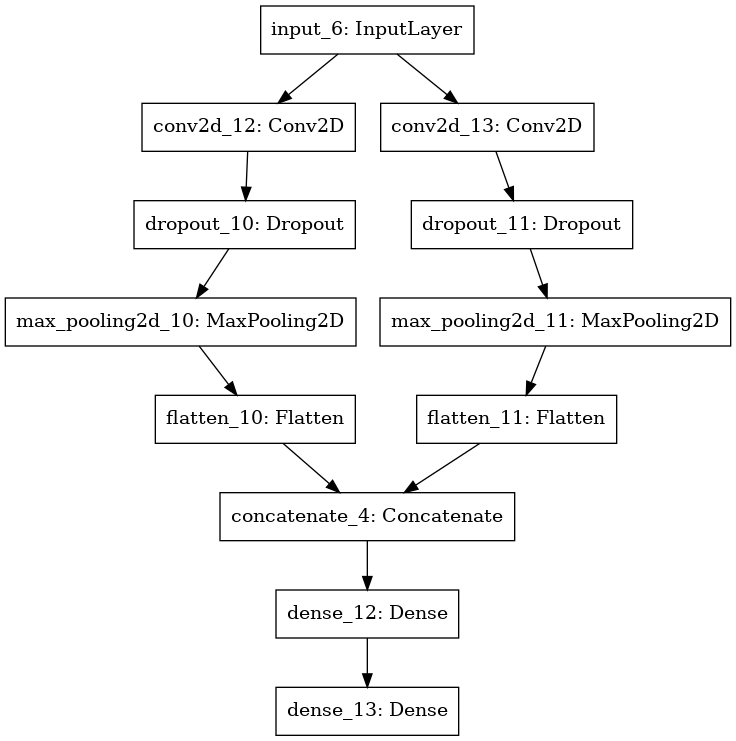

In [18]:
visible = Input(shape=(32,32,3,))

conv1 = Conv2D(64, kernel_size=(3,3), input_shape=(32,32,3,), activation='relu')(visible)
drop1 = Dropout(0.2)(conv1)
pool1 = MaxPooling2D((2,2))(drop1)
flat1 = Flatten()(pool1)

conv2 = Conv2D(64, kernel_size=(6,6), input_shape=(32,32,3,), activation='relu')(visible)
drop2 = Dropout(0.2)(conv2)
pool2 = MaxPooling2D((2,2))(drop2)
flat2 = Flatten()(pool2)

merge = concatenate([flat1, flat2])
hidden1 = Dense(100, activation='relu')(merge)
output = Dense(10, activation='softmax')(hidden1)

modelF_multiplePath = Model(inputs=visible, outputs=output)
modelF_multiplePath.summary()
plot_model(modelF_multiplePath)

In [19]:
checkpoint_multiplePath = ModelCheckpoint('model_mulpath_{epoch:03d}.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto')

modelF_multiplePath.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
logF2 = modelF_multiplePath.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=256, callbacks=[checkpoint_multiplePath])

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
49920/50000 [============================>.] - ETA: 0s - loss: 1.5934 - accuracy: 0.4333
Epoch 00001: val_accuracy improved from -inf to 0.53330, saving model to model_mulpath_001.h5
50000/50000 [==============================] - 10s 196us/sample - loss: 1.5929 - accuracy: 0.4334 - val_loss: 1.3397 - val_accuracy: 0.5333
Epoch 2/20
49920/50000 [============================>.] - ETA: 0s - loss: 1.2245 - accuracy: 0.5713
Epoch 00002: val_accuracy improved from 0.53330 to 0.58420, saving model to model_mulpath_002.h5
50000/50000 [==============================] - 9s 179us/sample - loss: 1.2245 - accuracy: 0.5714 - val_loss: 1.2077 - val_accuracy: 0.5842
Epoch 3/20
49920/50000 [============================>.] - ETA: 0s - loss: 1.1143 - accuracy: 0.6122
Epoch 00003: val_accuracy improved from 0.58420 to 0.59980, saving model to model_mulpath_003.h5
50000/50000 [==============================] - 9s 181us/sample - loss: 1.1140 - acc

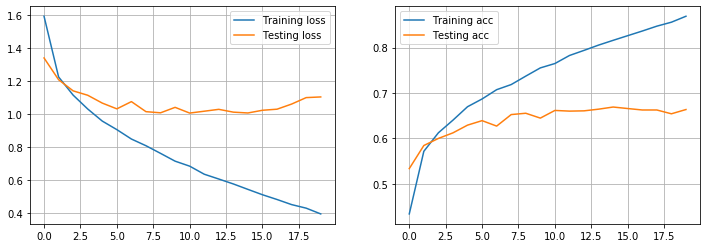

In [20]:
plot_log(logF2)

In [22]:
modelF_multiplePath.load_weights(filepath = 'model_mulpath_015.h5')
loss_test, metric_test = modelF_multiplePath.evaluate(X_test, Y_test, verbose=0)
loss_train, metric_train = modelF_multiplePath.evaluate(X_train, Y_train, verbose=0)
print('Test accuracy:', metric_test)
print('Test accuracy:', metric_train)

Test accuracy: 0.669
Test accuracy: 0.8501


## Experimental Model (#3): Multiple Features

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 30, 30, 32)   896         input_10[0][0]                   
__________________________________________________________________________________________________
dropout_21 (Dropout)            (None, 30, 30, 32)   0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 15, 15, 32)   0           dropout_21[0][0]                 
____________________________________________________________________________________________

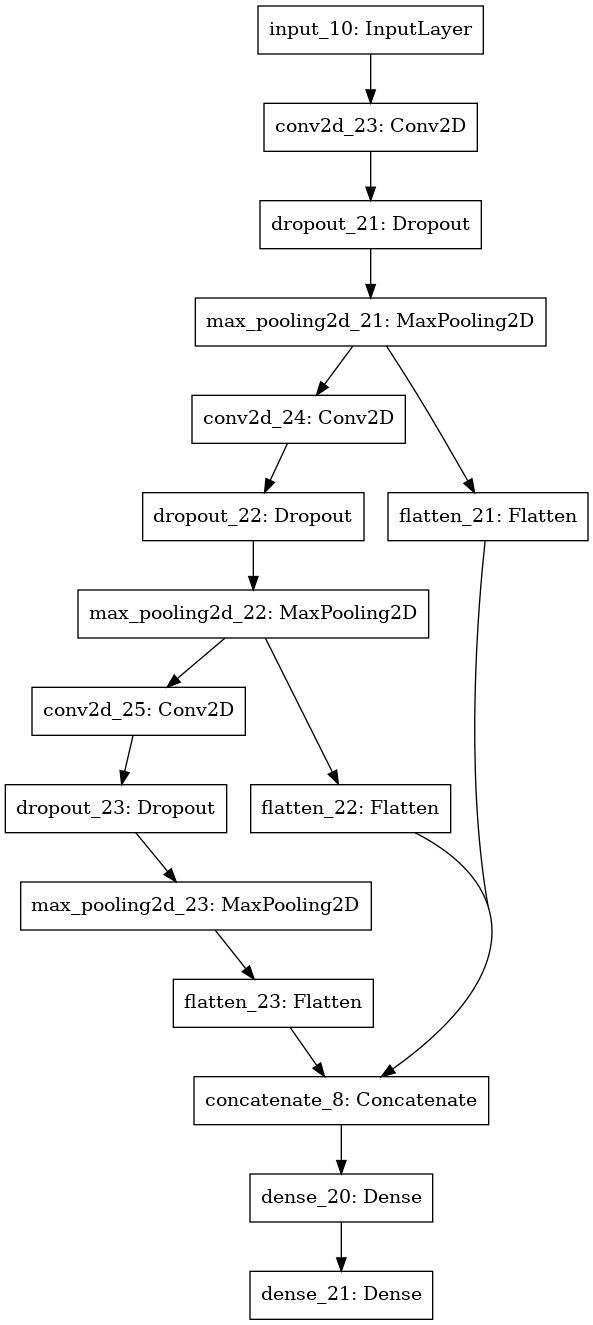

In [27]:
visible = Input(shape=(32,32,3,))

conv1 = Conv2D(32, kernel_size=(3,3), input_shape=(32,32,3,), activation='relu')(visible)
drop1 = Dropout(0.2)(conv1)
pool1 = MaxPooling2D((2,2))(drop1)
flat1 = Flatten()(pool1)

conv2 = Conv2D(32, kernel_size=(3,3), input_shape=(15,15,64,), activation='relu')(pool1)
drop2 = Dropout(0.2)(conv2)
pool2 = MaxPooling2D((2,2))(drop2)
flat2 = Flatten()(pool2)

conv3 = Conv2D(32, kernel_size=(3,3), input_shape=(6, 6, 32,), activation='relu')(pool2)
drop3 = Dropout(0.2)(conv3)
pool3 = MaxPooling2D((2,2))(drop3)
flat3 = Flatten()(pool3)

merge = concatenate([flat1, flat2, flat3])
hidden1 = Dense(100, activation='relu')(merge)
output = Dense(10, activation='softmax')(hidden1)

modelF_multipleFeatures = Model(inputs=visible, outputs=output)
modelF_multipleFeatures.summary()
plot_model(modelF_multipleFeatures)

In [29]:
checkpoint_multipleFeatures = ModelCheckpoint('model_mulfeat_{epoch:03d}.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto')

modelF_multipleFeatures.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
logF3 = modelF_multipleFeatures.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=256, callbacks=[checkpoint_multipleFeatures])

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
49664/50000 [============================>.] - ETA: 0s - loss: 1.6652 - accuracy: 0.4075
Epoch 00001: val_accuracy improved from -inf to 0.50430, saving model to model_mulfeat_001.h5
50000/50000 [==============================] - 6s 121us/sample - loss: 1.6633 - accuracy: 0.4083 - val_loss: 1.4185 - val_accuracy: 0.5043
Epoch 2/20
49664/50000 [============================>.] - ETA: 0s - loss: 1.2772 - accuracy: 0.5466
Epoch 00002: val_accuracy improved from 0.50430 to 0.55960, saving model to model_mulfeat_002.h5
50000/50000 [==============================] - 5s 95us/sample - loss: 1.2758 - accuracy: 0.5474 - val_loss: 1.2611 - val_accuracy: 0.5596
Epoch 3/20
49664/50000 [============================>.] - ETA: 0s - loss: 1.1475 - accuracy: 0.5981
Epoch 00003: val_accuracy improved from 0.55960 to 0.58150, saving model to model_mulfeat_003.h5
50000/50000 [==============================] - 5s 95us/sample - loss: 1.1470 - accura

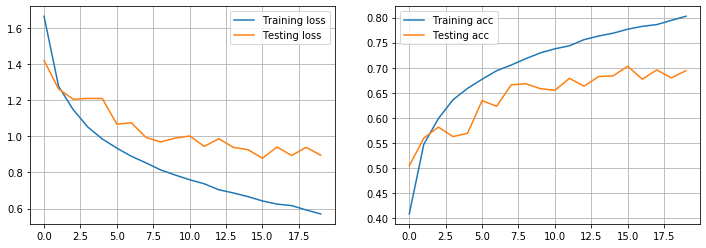

In [30]:
plot_log(logF3)

In [32]:
modelF_multipleFeatures.load_weights(filepath = 'model_mulfeat_016.h5')
loss_test, metric_test = modelF_multipleFeatures.evaluate(X_test, Y_test, verbose=0)
loss_train, metric_train = modelF_multipleFeatures.evaluate(X_train, Y_train, verbose=0)
print('Test accuracy:', metric_test)
print('Test accuracy:', metric_train)

Test accuracy: 0.7029
Test accuracy: 0.79292


## Experimental Model (#4): Multiple Paths with Multiple Features

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 32, 32, 32)   896         input_13[0][0]                   
__________________________________________________________________________________________________
dropout_31 (Dropout)            (None, 32, 32, 32)   0           conv2d_33[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D) (None, 16, 16, 32)   0           dropout_31[0][0]                 
___________________________________________________________________________________________

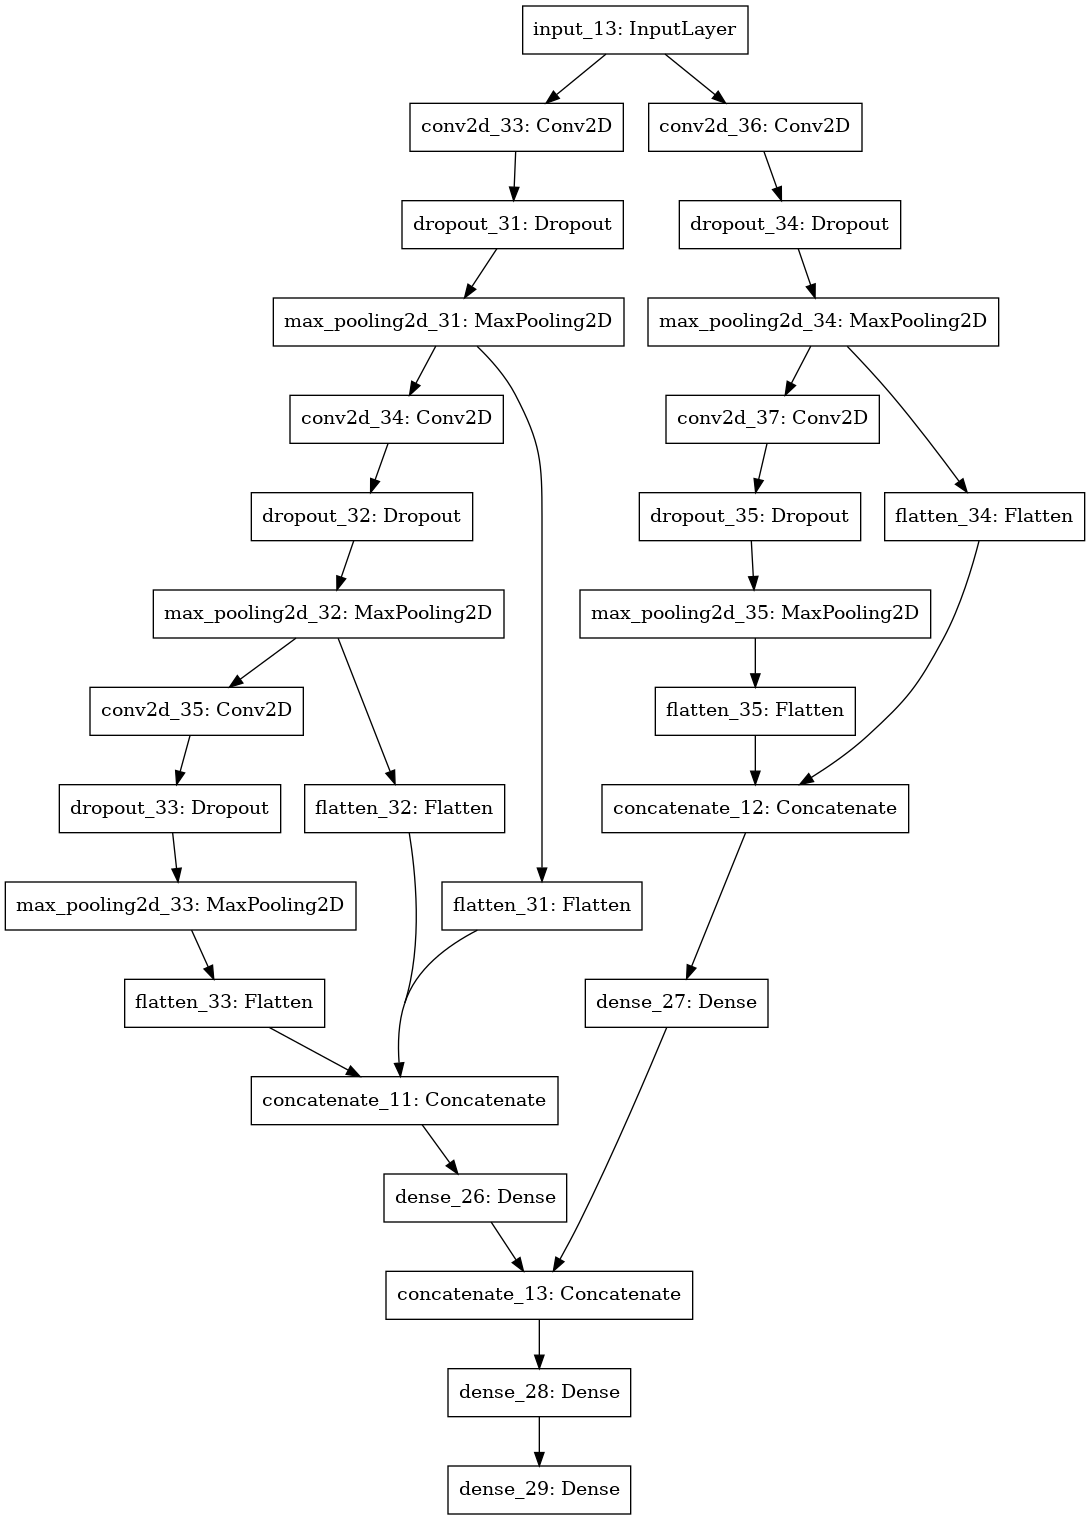

In [35]:
visible = Input(shape=(32,32,3,))

# Path 1
conv1 = Conv2D(32, kernel_size=(3,3), input_shape=(32,32,3,), activation='relu', padding='same')(visible)
drop1 = Dropout(0.2)(conv1)
pool1 = MaxPooling2D((2,2))(drop1)
flat1 = Flatten()(pool1)

conv2 = Conv2D(32, kernel_size=(3,3), input_shape=(16,16,64,), activation='relu', padding='same')(pool1)
drop2 = Dropout(0.2)(conv2)
pool2 = MaxPooling2D((2,2))(drop2)
flat2 = Flatten()(pool2)

conv3 = Conv2D(32, kernel_size=(3,3), input_shape=(8, 8, 32,), activation='relu', padding='same')(pool2)
drop3 = Dropout(0.2)(conv3)
pool3 = MaxPooling2D((2,2))(drop3)
flat3 = Flatten()(pool3)

merge1 = concatenate([flat1, flat2, flat3])
hidden1 = Dense(100, activation='relu')(merge1)

# Path 2
conv4 = Conv2D(32, kernel_size=(6,6), input_shape=(32,32,3,), activation='relu', padding='same')(visible)
drop4 = Dropout(0.2)(conv4)
pool4 = MaxPooling2D((2,2))(drop4)
flat4 = Flatten()(pool4)

conv5 = Conv2D(32, kernel_size=(3,3), input_shape=(16,16,64,), activation='relu', padding='same')(pool4)
drop5 = Dropout(0.2)(conv5)
pool5 = MaxPooling2D((2,2))(drop5)
flat5 = Flatten()(pool5)

merge2 = concatenate([flat4, flat5])
hidden2 = Dense(100, activation='relu')(merge2)

merge3 = concatenate([hidden1,hidden2])
hidden3 = Dense(100, activation='relu')(merge3)
output = Dense(10, activation='softmax')(hidden3)

modelF_combined = Model(inputs=visible, outputs=output)
modelF_combined.summary()
plot_model(modelF_combined)

In [36]:
checkpoint_combined = ModelCheckpoint('model_comb_{epoch:03d}.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto')

modelF_combined.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
logF4 = modelF_combined.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=256, callbacks=[checkpoint_combined])

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
49664/50000 [============================>.] - ETA: 0s - loss: 1.5625 - accuracy: 0.4403
Epoch 00001: val_accuracy improved from -inf to 0.54840, saving model to model_comb_001.h5
50000/50000 [==============================] - 11s 216us/sample - loss: 1.5605 - accuracy: 0.4411 - val_loss: 1.3135 - val_accuracy: 0.5484
Epoch 2/20
49920/50000 [============================>.] - ETA: 0s - loss: 1.1828 - accuracy: 0.5827
Epoch 00002: val_accuracy improved from 0.54840 to 0.60450, saving model to model_comb_002.h5
50000/50000 [==============================] - 9s 180us/sample - loss: 1.1826 - accuracy: 0.5828 - val_loss: 1.1475 - val_accuracy: 0.6045
Epoch 3/20
49920/50000 [============================>.] - ETA: 0s - loss: 1.0323 - accuracy: 0.6352
Epoch 00003: val_accuracy improved from 0.60450 to 0.64370, saving model to model_comb_003.h5
50000/50000 [==============================] - 9s 182us/sample - loss: 1.0330 - accuracy: 0.

Test accuracy: 0.721
Test accuracy: 0.9175


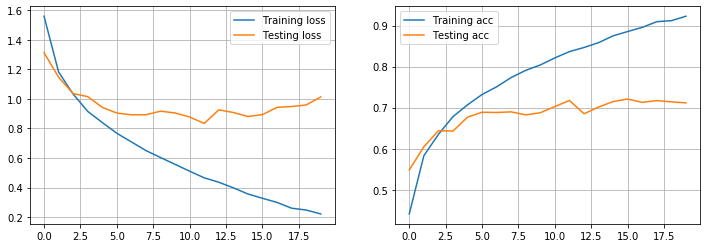

In [37]:
plot_log(logF4)
modelF_combined.load_weights(filepath = 'model_comb_016.h5')
loss_test, metric_test = modelF_combined.evaluate(X_test, Y_test, verbose=0)
loss_train, metric_train = modelF_combined.evaluate(X_train, Y_train, verbose=0)
print('Test accuracy:', metric_test)
print('Test accuracy:', metric_train)

## Experimental Model (#5): Multiple Paths with Multiple Features v2

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_187 (Conv2D)             (None, 32, 32, 64)   1792        input_27[0][0]                   
__________________________________________________________________________________________________
dropout_187 (Dropout)           (None, 32, 32, 64)   0           conv2d_187[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_187 (MaxPooling2D (None, 16, 16, 64)   0           dropout_187[0][0]                
___________________________________________________________________________________________

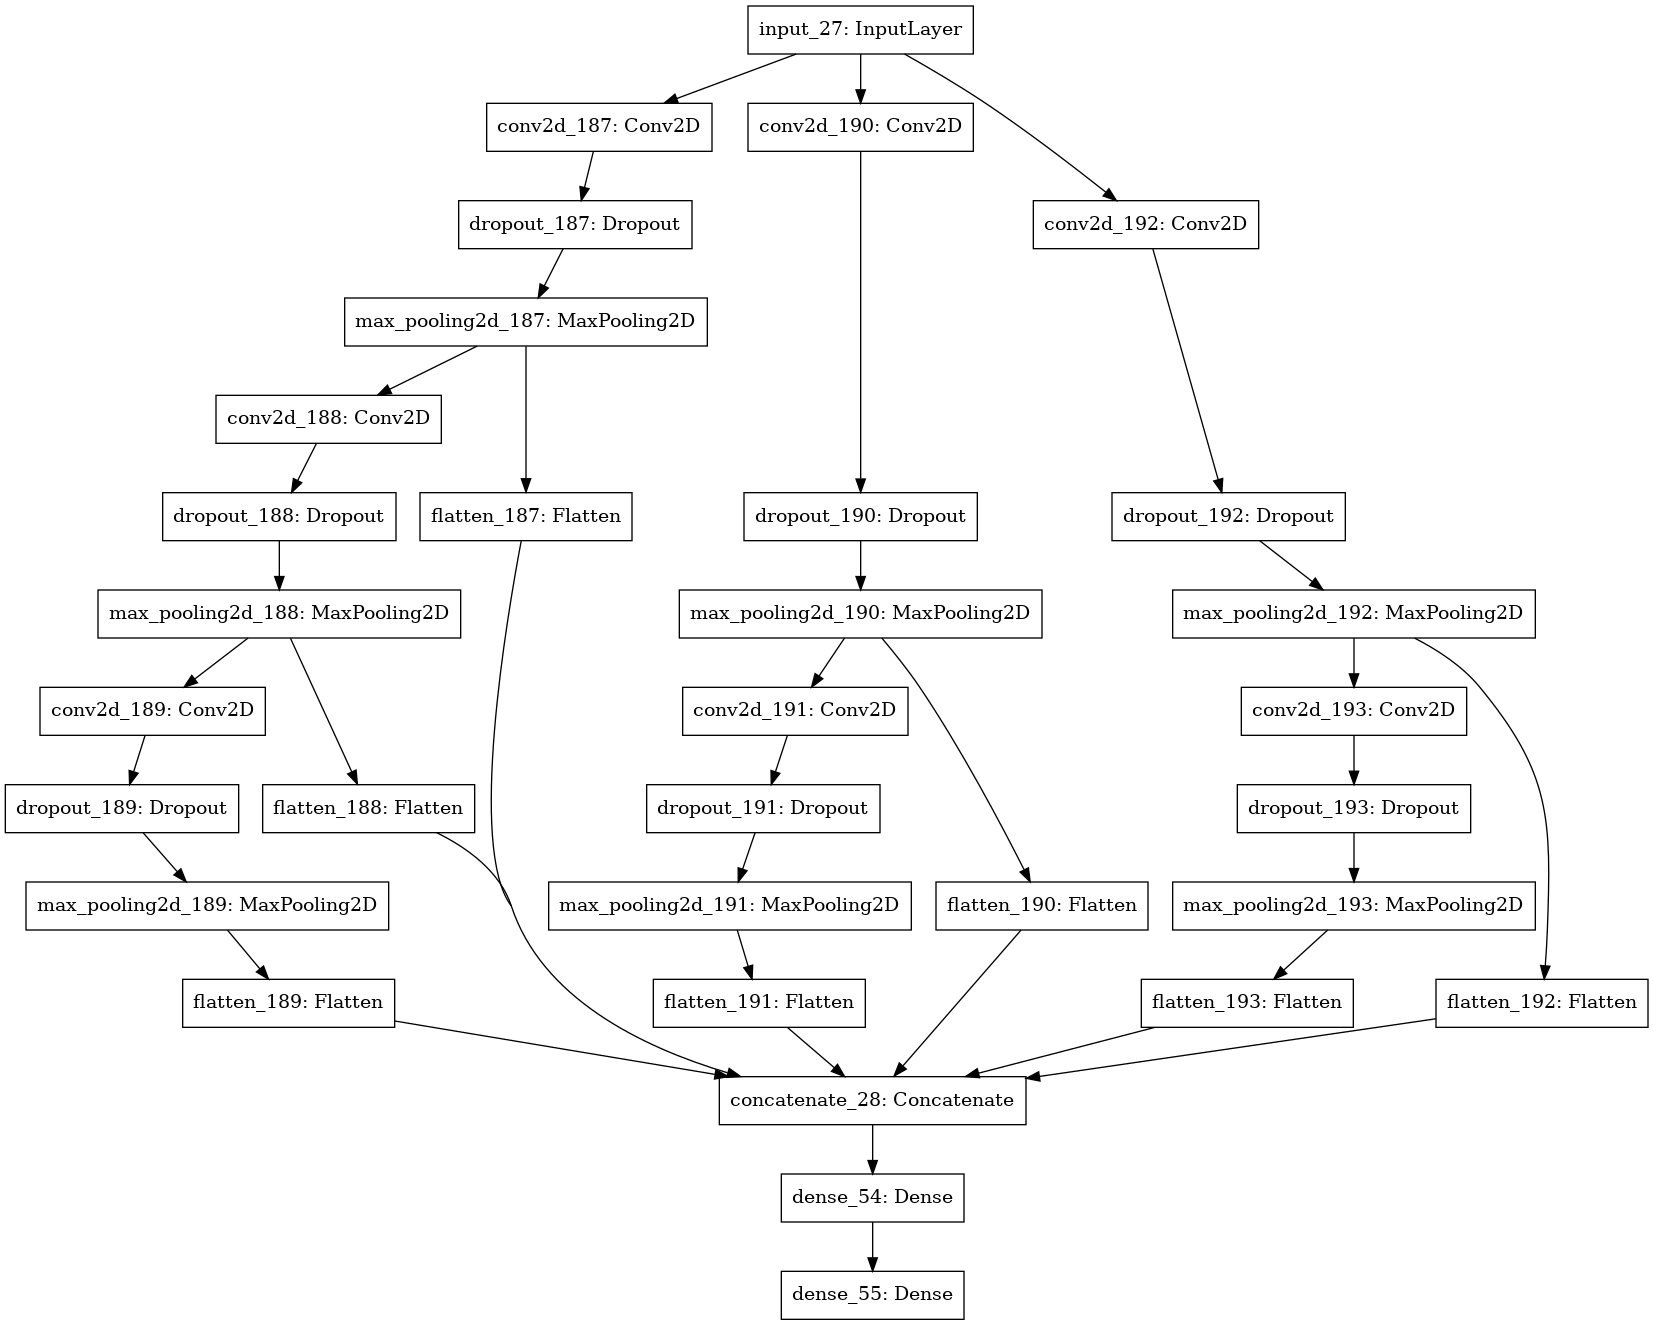

In [47]:
visible = Input(shape=(32,32,3,))

# Path 1
conv1 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(visible)
drop1 = Dropout(0.2)(conv1)
pool1 = MaxPooling2D((2,2))(drop1)
flat1 = Flatten()(pool1)

conv2 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(pool1)
drop2 = Dropout(0.2)(conv2)
pool2 = MaxPooling2D((2,2))(drop2)
flat2 = Flatten()(pool2)

conv3 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(pool2)
drop3 = Dropout(0.2)(conv3)
pool3 = MaxPooling2D((2,2))(drop3)
flat3 = Flatten()(pool3)

# merge1 = concatenate([flat1, flat2, flat3])
# hidden1 = Dense(128, activation='relu')(merge1)

# Path 2
conv4 = Conv2D(64, kernel_size=(6,6), activation='relu', padding='same')(visible)
drop4 = Dropout(0.2)(conv4)
pool4 = MaxPooling2D((2,2))(drop4)
flat4 = Flatten()(pool4)

conv5 = Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')(pool4)
drop5 = Dropout(0.2)(conv5)
pool5 = MaxPooling2D((2,2))(drop5)
flat5 = Flatten()(pool5)

# Path 3
conv6 = Conv2D(64, kernel_size=(9,9), activation='relu')(visible)
drop6 = Dropout(0.2)(conv6)
pool6 = MaxPooling2D((2,2))(drop6)
flat6 = Flatten()(pool6)

conv7 = Conv2D(64, kernel_size=(3,3), activation='relu')(pool6)
drop7 = Dropout(0.2)(conv7)
pool7 = MaxPooling2D((2,2))(drop7)
flat7 = Flatten()(pool7)

# merge2 = concatenate([flat4, flat5, flat6])
# hidden2 = Dense(128, activation='relu')(merge2)

merge3 = concatenate([flat1, flat2, flat3, flat4, flat5, flat6, flat7])
hidden3 = Dense(128, activation='relu')(merge3)
output = Dense(10, activation='softmax')(hidden3)

modelF_combined2 = Model(inputs=visible, outputs=output)
modelF_combined2.summary()
plot_model(modelF_combined2)

In [48]:
checkpoint_combined2 = ModelCheckpoint('model_comb2_{epoch:03d}.h5', verbose=1, monitor='val_accuracy', save_best_only=True, mode='auto')

modelF_combined2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
logF5 = modelF_combined2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=256, callbacks=[checkpoint_combined2])

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
49920/50000 [============================>.] - ETA: 0s - loss: 1.7505 - accuracy: 0.3944
Epoch 00001: val_accuracy improved from -inf to 0.52130, saving model to model_comb2_001.h5
50000/50000 [==============================] - 23s 460us/sample - loss: 1.7499 - accuracy: 0.3946 - val_loss: 1.3978 - val_accuracy: 0.5213
Epoch 2/20
49920/50000 [============================>.] - ETA: 0s - loss: 1.2262 - accuracy: 0.5666
Epoch 00002: val_accuracy improved from 0.52130 to 0.52280, saving model to model_comb2_002.h5
50000/50000 [==============================] - 21s 426us/sample - loss: 1.2259 - accuracy: 0.5668 - val_loss: 1.3258 - val_accuracy: 0.5228
Epoch 3/20
49920/50000 [============================>.] - ETA: 0s - loss: 1.0635 - accuracy: 0.6276
Epoch 00003: val_accuracy improved from 0.52280 to 0.59420, saving model to model_comb2_003.h5
50000/50000 [==============================] - 21s 427us/sample - loss: 1.0633 - accurac

Test accuracy: 0.7106
Test accuracy: 0.94214


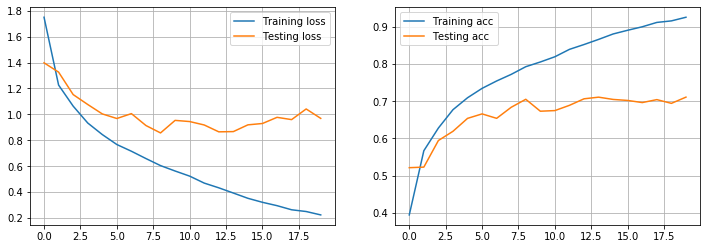

In [49]:
plot_log(logF5)
modelF_combined2.load_weights(filepath = 'model_comb2_020.h5')
loss_test, metric_test = modelF_combined2.evaluate(X_test, Y_test, verbose=0)
loss_train, metric_train = modelF_combined2.evaluate(X_train, Y_train, verbose=0)
print('Test accuracy:', metric_test)
print('Test accuracy:', metric_train)

* Use callbacks to save the best trained models according to a monitoring of the accuracy on the test set. Report on your experiments and describe your best configuration through experimenting with 3-4 different architectures. Use a table similar to the example given below and provide the hyper-parameters used for your configurations.

| Model | Architecture | Callback | Acc. train % | Acc. test % |
|-------|--------------|----------|--------------|-------------|
| 1     | Base Model for Reference, 2x Conv2D (64, 32), MPool, Dense(128), Dropout | no       | 0.6932           | 0.6957          |
| 2     | Fn.Model with 2 Paths, (conv2D(3x3) and conv2d(6x6), DO, MPool, Concat, Dense(100)           | yes       | 0.8501          | 0.669          |
| 3     | Fn.Model with 3 Features, each with [conv2D(32, 3x3),DP, MPool]          | yes      | 0.79292          | 0.7029         |
| 4     | Fn.Model with 2 Paths with 5 Features (path1: 3feat, path2: 2feat)<br>each path with one Dense(100) layer at the end | yes       | 0.9175           | 0.721          |
| 5 v5    | Fn.Model with 3 Paths with 7 Features (3+2+2), Conv2D with 64 filters<br>all combined with one Dense(128) layer at the end            | yes       | 0.94214           | 0.7106          |

Other results from changing Model 5 hyperparameters:

Model 5v1: test: accuracy: 0.7129, train: accuracy: 0.90608<br >
Model 5v2: test: accuracy: 0.7125, train: accuracy: 0.90294<br >
Model 5v3: test: accuracy: 0.7168, train: accuracy: 0.8582<br >
Model 5v4: test: accuracy: 0.7193, train: accuracy: 0.92018<br >
Model 5v5: test: accuracy: 0.7106, train: accuracy: 0.94214
